In [13]:
from PIL import Image, ImageDraw
from IPython.display import display


import rasterio
import matplotlib.pyplot as plt
import os
import random
import shutil
import yaml
from pathlib import Path
from imantics import  Mask
from shapely.geometry import Polygon
import numpy as np

In [14]:


def find_files(directory, extension):
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                matching_files.append(Path(root) / file)
    return matching_files

In [15]:
def sort_points_clockwise(points):

    centroid = np.mean(points, axis=0)

    angles = np.arctan2(points[:, 1] - centroid[1], points[:, 0] - centroid[0])

    return points[np.argsort(angles)]

def mask_to_yolo_segmentation(mask_path, output_path):
    with rasterio.open(mask_path) as fin:
        mask = fin.read(1)
    mask = Image.fromarray(mask).convert('L')
    mask_array = np.array(mask)

    yolo_annotations = []
    class_label = 1

    plt.imshow(mask_array)


    mask_obj = Mask(mask_array)

    polygons = mask_obj.polygons()

    for polygon in polygons.points:

        normalized_polygon = [(x / mask_array.shape[1], y / mask_array.shape[0]) for x, y in polygon]
        flat_polygon = [coord for point in normalized_polygon for coord in point]

        flat_polygon = sort_points_clockwise(np.reshape(flat_polygon, (-1, 2))).flatten()

        annotation = f"{class_label} " + " ".join(map(str, flat_polygon))
        yolo_annotations.append(annotation)

    return yolo_annotations

def write_yolo_segm(output_path, yolo_annotations):
    with open(output_path, "w") as file:
        for obj_info in yolo_annotations:
            line = obj_info
            file.writelines(line + '\n')



In [11]:
root_dir  = Path('/home/user1/xakaton2024/')

In [17]:
exp_dir = root_dir /'data/yolo_channels_NIR'

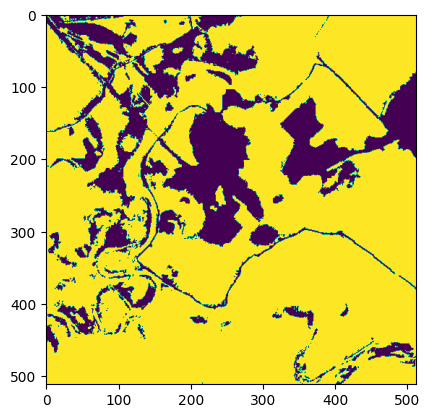

In [20]:
%matplotlib inline

# MASKS TO YOLO

files =  find_files( root_dir / 'data/cut_data/masks', "tif")
output_path = exp_dir / 'labels/'
os.makedirs(output_path, exist_ok=True)

for file in files:
    objects_info = mask_to_yolo_segmentation(file, output_path)

    write_yolo_segm(Path(output_path) / Path(str(file.stem)+'.txt'), objects_info)
   
  

In [ ]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min) / ((band_max - band_min)))

def brighten(band):
    alpha = 0.13
    beta = 0
    return np.clip(alpha * band + beta, 0, 255)



def convert(im_path, rgb = (3, 2, 1)):
    r, g, b = rgb
    with rasterio.open(im_path) as fin:
        #red = fin.read(r)
        #green = fin.read(g)
        #blue = fin.read(b)
        green = 2
        NIR = fin.read(7)
        SNIR = fin.read(9)
        NNIR = fin.read(8)


    red_b = brighten(SNIR)
    blue_b = brighten((green - NIR)/(green + NIR))
    green_b = brighten((green - NNIR)/(green + NNIR))

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    
    return np.dstack((blue_bn, red_bn, blue_bn )), np.dstack((blue_bn, red_bn, green_bn ))
    #return np.dstack((blue_b, green_b, red_b)), np.dstack((red_bn, green_bn, blue_bn))


def tif_to_png(image_path, output_directory, rgb):

    _, img = convert(image_path, rgb)
    #plt.imshow(img)
    output_file = Path(output_directory) / (Path(image_path).stem + '.png')
    img = Image.fromarray((img*255).astype('uint8'), 'RGB')
    img.save(output_file)

In [ ]:
output_directory = exp_dir / 'data/rgb_9/'
image_path = root_dir /'data/cut_data_9/images'

os.makedirs(output_directory, exist_ok=True)

imgs = find_files(image_path, "tif")

In [33]:
for file in imgs:
    tif_to_png(file, output_directory, (3,2,1))

/tmp/ipykernel_37248/1892909889.py:3: RuntimeWarning: invalid value encountered in divide
  return ((band - band_min) / ((band_max - band_min)))
/tmp/ipykernel_37248/1892909889.py:42: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img*255).astype('uint8'), 'RGB')


In [43]:
DATASET_DIR = exp_dir
SAVE_SPLIT_DIR = root_dir/ 'data' /'yolo_split_dataset_NIR/'

SIZE_VALID = 0.2

In [44]:
path_train = os.path.join(SAVE_SPLIT_DIR, 'train')
os.makedirs(path_train,exist_ok=True)
path_train_images = os.path.join(path_train, 'images')
os.makedirs(path_train_images, exist_ok=True)
path_train_labels = os.path.join(path_train, 'labels')
os.makedirs(path_train_labels, exist_ok=True)

path_valid = os.path.join(SAVE_SPLIT_DIR, 'val')
os.makedirs(path_valid, exist_ok=True)
path_valid_images = os.path.join(path_valid, 'images')
os.makedirs(path_valid_images, exist_ok=True)
path_valid_labels = os.path.join(path_valid, 'labels')
os.makedirs(path_valid_labels, exist_ok=True)

path_images = os.path.join(DATASET_DIR, 'images')
path_labels = os.path.join(DATASET_DIR, 'labels')

images = os.listdir(path_images)

valid_images = random.sample(images, int(len(images) * SIZE_VALID))
print(f'Size valid = {len(valid_images)}')
for filename in images:
    only_filename = filename[:-4]

    if filename in valid_images:
        shutil.copyfile(
            os.path.join(path_images, f'{only_filename}.png'),
            os.path.join(path_valid_images, f'{only_filename}.png'),
        )
        shutil.copyfile(
            os.path.join(path_labels, f'{only_filename}.txt'),
            os.path.join(path_valid_labels, f'{only_filename}.txt'),
        )
    else:
        shutil.copyfile(
            os.path.join(path_images, f'{only_filename}.png'),
            os.path.join(path_train_images, f'{only_filename}.png'),
        )
        shutil.copyfile(
            os.path.join(path_labels, f'{only_filename}.txt'),
            os.path.join(path_train_labels, f'{only_filename}.txt'),
        )

Size valid = 142


In [51]:
import json

In [37]:
txts = find_files(exp_dir, 'txt')

In [38]:
txts

[PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_1_73.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_61.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_111.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_93.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_47.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_2_73.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_19.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_1_64.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_268.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_109.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_2_56.txt'),
 PosixPath('/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_204

In [39]:
def read_yolo_segmentation_txt(file_path):
    
    annotations = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 1:
                class_id = int(parts[0])
                polygon_points = [float(coord) for coord in parts[1:]]
                annotations.append([class_id] + polygon_points)
                if len(polygon_points)=2:
                    print(file_path)
    return np.array(annotations, dtype=object)



image_width = 640  # Replace with your image width
image_height = 640  # Replace with your image height
for file in txts:
    bboxes = read_yolo_segmentation_txt(file)
    # if len(bboxes)==5:
    #     print(file)

/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_1_64.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_268.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_204.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_204.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_216.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_6_1_15.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_279.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_279.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_279.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_282.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_282.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_282.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_254.txt
/home/user1/xakaton2024/data/yolo_channels_NIR/labels/tile_1_239.txt
/home/user1/xakaton2024/data/yol

In [73]:
from ultralytics import YOLO
import torch

model = YOLO("yolo11l-seg.pt")
model.to('cuda')

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, tra

In [ ]:
model.train(data='yolov11_seg_flood.yaml', retina_masks=True, epochs=1000)

engine/trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=yolov11_seg_flood.yaml, epochs=1000, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=True, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8

train: Scanning /home/user1/xakaton2024/data/yolo_split_dataset_NIR/train/labels.cache... 572 images, 80 backgrounds, 1 corrupt: 100%|██████████| 572/572 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/user1/xakaton2024/data/yolo_split_dataset_NIR/train/images/tile_1_215.png: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.



val: Scanning /home/user1/xakaton2024/data/yolo_split_dataset_NIR/val/labels.cache... 142 images, 20 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train3
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     1/1000      13.3G      2.015       4.26      3.319      1.471         94        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        142       1901     0.0069       0.13    0.00377    0.00164    0.00484     0.0921    0.00256    0.00115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      13.4G      2.309      4.046      2.402      1.637        190        640: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

                   all        142       1901   0.000256    0.00263   0.000129   3.61e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      13.5G      2.502      4.068       2.61      1.756        169        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        142       1901   0.000256    0.00263   0.000129   3.61e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      13.6G      2.453      4.031      2.362      1.736        130        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        142       1901     0.0194     0.0231    0.00381    0.00148     0.0164     0.0195     0.0033    0.00134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      13.5G      2.424      3.952      2.379      1.752         78        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all        142       1901     0.0194     0.0231    0.00381    0.00148     0.0164     0.0195     0.0033    0.00134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      13.4G      2.374      3.859      2.266       1.69        285        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


                   all        142       1901       0.03      0.161     0.0124    0.00468     0.0277      0.158     0.0103    0.00374

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      13.5G      2.319      3.803       2.15       1.66        216        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


                   all        142       1901      0.228      0.121     0.0776     0.0312      0.245      0.131     0.0866     0.0307

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      13.4G      2.264      3.768      2.206      1.599        169        640: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


                   all        142       1901      0.289      0.155      0.107     0.0456      0.227      0.153     0.0964     0.0326

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      13.5G      2.236      3.761      2.132      1.571        193        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


                   all        142       1901      0.303      0.183      0.136     0.0589       0.28      0.155      0.116     0.0423

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      13.5G      2.211      3.735      2.117       1.57        114        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


                   all        142       1901      0.281       0.15        0.1     0.0424      0.277      0.145     0.0963     0.0352

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      13.6G      2.226      3.726      2.099      1.574        155        640: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.315      0.159      0.113     0.0478      0.284      0.144     0.0983     0.0362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      13.5G       2.18      3.677      2.051      1.549        193        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        142       1901      0.264      0.178      0.115     0.0465      0.236      0.161      0.101     0.0346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      13.5G      2.117      3.597      1.937      1.516        102        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901       0.29      0.213      0.134     0.0599      0.252      0.189      0.114     0.0422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      13.4G       2.14      3.654      1.987       1.54        159        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        142       1901      0.276       0.17      0.127     0.0562      0.244       0.14     0.0992     0.0366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      13.6G      2.095      3.632      1.916       1.47         81        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901      0.303      0.179      0.133     0.0566      0.321      0.178      0.138     0.0506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      13.5G      2.055      3.566      1.912      1.479        188        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        142       1901       0.32      0.181      0.129      0.053      0.299      0.161      0.114     0.0387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      13.5G      2.058       3.65      1.956      1.492         94        640: 100%|██████████| 36/36 [00:15<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        142       1901       0.31      0.198      0.148     0.0639      0.243       0.19      0.124     0.0447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      13.5G      2.037       3.47      1.886      1.454        160        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.321      0.196      0.141     0.0636      0.269      0.173      0.122     0.0419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      13.5G      2.063      3.578      1.969      1.487         77        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


                   all        142       1901      0.305      0.193      0.143     0.0628       0.28      0.163      0.119     0.0433

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      13.6G      2.082      3.505      1.923      1.496        206        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.326      0.216      0.156     0.0677      0.297      0.198      0.137     0.0524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      13.5G      1.997       3.52      1.853      1.449        217        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        142       1901      0.322      0.184      0.152     0.0701      0.268      0.163      0.129     0.0461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      13.5G      2.057      3.486      1.901      1.478        128        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        142       1901      0.353      0.191      0.153     0.0683      0.329      0.178      0.138     0.0515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      13.5G      1.955      3.477      1.793      1.442         86        640: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.322      0.197      0.152     0.0682      0.286      0.184      0.136     0.0496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      13.4G      2.007      3.448      1.826      1.425        206        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142       1901      0.341       0.19      0.156      0.068      0.332      0.175      0.144     0.0531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      13.5G      1.982      3.471      1.789      1.445        251        640: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.367      0.205      0.169     0.0741      0.346      0.193      0.154     0.0558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      13.5G      2.012      3.503      1.823      1.445        195        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        142       1901      0.343      0.191      0.159     0.0711      0.316      0.174      0.138     0.0514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      13.5G      1.968      3.387      1.797      1.403         98        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901       0.34      0.216      0.173     0.0785      0.289       0.21      0.159     0.0583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      13.4G      1.948       3.37       1.76      1.397        151        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


                   all        142       1901      0.377      0.219      0.179     0.0784      0.348      0.211      0.175      0.064

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      13.5G      1.926      3.386       1.76      1.429        174        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


                   all        142       1901      0.383      0.181      0.157     0.0729      0.363      0.161      0.139     0.0504

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      13.5G      1.937      3.345      1.767      1.395         73        640: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        142       1901      0.338      0.205      0.172     0.0744      0.308      0.167      0.138     0.0478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      13.4G       1.95      3.351      1.773      1.413        216        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.384      0.191      0.165     0.0738      0.357      0.166      0.139     0.0502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      13.6G      1.898      3.293      1.718      1.378        217        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.398      0.211      0.187     0.0834      0.351      0.197      0.165     0.0591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      13.6G      1.894      3.346      1.714      1.398        218        640: 100%|██████████| 36/36 [00:14<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        142       1901      0.367      0.189      0.172     0.0814      0.332      0.165      0.154     0.0572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      13.4G      1.898      3.322      1.713      1.372        202        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        142       1901      0.368      0.197      0.172     0.0811      0.322      0.184      0.151     0.0575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      13.5G      1.924      3.323      1.767      1.408        211        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        142       1901      0.418       0.21      0.189     0.0814      0.355       0.19      0.162     0.0592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      13.4G      1.948      3.367      1.816      1.421        187        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901       0.38      0.211      0.186     0.0839      0.352      0.195      0.169      0.059



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      13.5G       1.89      3.334      1.739      1.386         89        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142       1901      0.385      0.217      0.176     0.0776      0.317      0.179      0.136     0.0492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      13.4G      1.887      3.296      1.672      1.388        104        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901      0.292       0.14      0.121     0.0587      0.266      0.128      0.108      0.043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      13.6G      1.922      3.336      1.784      1.409         92        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        142       1901      0.387      0.214       0.18     0.0854      0.357      0.194       0.16     0.0593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      13.6G      1.892      3.345      1.723      1.411        134        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142       1901      0.392      0.208      0.174     0.0789      0.354      0.183      0.151     0.0565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      13.5G      1.853      3.292      1.679      1.357         96        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.355      0.208      0.171     0.0778      0.323      0.202      0.159     0.0581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      13.5G      1.833      3.266      1.634      1.344        152        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.392      0.214      0.182     0.0841      0.363      0.201      0.167     0.0619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      13.4G      1.847      3.272      1.694      1.372        119        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        142       1901      0.343      0.222      0.177     0.0804       0.31      0.203      0.154     0.0565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      13.5G      1.852      3.225       1.68      1.371        108        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        142       1901      0.377      0.214      0.177     0.0823      0.334      0.201      0.161     0.0587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      13.5G      1.867      3.311      1.706      1.395        163        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.411      0.216      0.185     0.0832      0.375      0.199      0.172     0.0622



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      13.5G      1.819      3.232      1.613      1.333        155        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.387      0.221      0.189     0.0823      0.359      0.207       0.17     0.0598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    47/1000      13.6G      1.838      3.231      1.649       1.35        132        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.374      0.213      0.183     0.0808       0.31      0.188      0.147     0.0529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    48/1000      13.5G      1.792      3.167      1.608      1.344        142        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.349      0.217      0.184     0.0888      0.298      0.199       0.16      0.059



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    49/1000      13.5G      1.859      3.274      1.685       1.36         96        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901       0.39      0.233        0.2      0.089      0.349      0.219      0.179     0.0646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    50/1000      13.6G      1.807      3.171       1.62      1.337        126        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.364      0.227      0.189     0.0892      0.313      0.207      0.165     0.0612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    51/1000      13.5G      1.877       3.27      1.741      1.367        255        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142       1901      0.377      0.215      0.186     0.0837      0.335      0.195      0.162     0.0587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    52/1000      13.4G      1.796      3.152      1.572      1.314        100        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        142       1901      0.398       0.24        0.2      0.089      0.373      0.229      0.187     0.0693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    53/1000      13.5G      1.816      3.204      1.626      1.342         59        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        142       1901      0.383      0.226      0.188      0.085      0.352       0.21      0.172     0.0601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      13.4G      1.815      3.211      1.615      1.329        133        640: 100%|██████████| 36/36 [00:14<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.397      0.225      0.192     0.0883      0.331      0.195      0.153     0.0569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    55/1000      13.4G      1.812      3.174      1.679      1.331         85        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142       1901      0.419      0.236      0.207     0.0913      0.328       0.21      0.174     0.0613



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    56/1000      13.6G      1.794      3.183      1.694      1.337        227        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901      0.363      0.223      0.189     0.0873      0.308      0.195      0.159       0.06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    57/1000      13.5G       1.82      3.202      1.586      1.348        147        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        142       1901      0.376      0.208      0.182     0.0789      0.337       0.18      0.152     0.0538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    58/1000      13.5G       1.74      3.151      1.597      1.302        192        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        142       1901      0.357      0.218      0.181     0.0869      0.314      0.189      0.154     0.0595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    59/1000      13.5G      1.734      3.093      1.541        1.3        113        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901      0.381      0.228      0.199     0.0906      0.331      0.221      0.175      0.065



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    60/1000      13.8G        1.8      3.177      1.617      1.327        151        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.422      0.234      0.201     0.0901      0.341       0.21      0.168     0.0612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    61/1000      13.5G      1.755       3.12      1.558        1.3        103        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142       1901      0.414      0.215      0.193     0.0909      0.358      0.191      0.164     0.0614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    62/1000      13.5G      1.798      3.226      1.611      1.312        159        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.393      0.225      0.195     0.0923      0.328       0.22      0.175     0.0649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    63/1000      13.5G      1.729      3.081      1.522      1.276        199        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        142       1901      0.393      0.225      0.197     0.0911      0.341      0.216      0.177     0.0653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    64/1000      13.4G      1.802      3.102      1.596      1.315         87        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142       1901      0.422      0.234      0.203     0.0911      0.348       0.21      0.172     0.0632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    65/1000      13.5G      1.771      3.131      1.542      1.306         63        640: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142       1901      0.391      0.229      0.198     0.0908      0.347      0.203       0.17     0.0634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    66/1000      13.5G      1.746      3.147      1.584        1.3        174        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142       1901       0.42      0.217      0.194     0.0892      0.353      0.191      0.163     0.0587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    67/1000      13.4G      1.732      3.109      1.582      1.301        216        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142       1901        0.4      0.218      0.192     0.0893      0.375      0.196      0.174     0.0655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    68/1000      13.5G      1.738      3.105      1.547      1.286        140        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        142       1901      0.404      0.223      0.196     0.0862      0.358       0.21      0.176     0.0628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    69/1000      13.5G       1.74      3.093      1.577      1.306        179        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.398      0.224      0.196     0.0883      0.364      0.216      0.181     0.0648



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    70/1000      13.6G      1.725      3.107      1.554      1.299         96        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        142       1901      0.407      0.235      0.203     0.0937      0.345      0.225      0.179     0.0644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    71/1000      13.5G      1.698      3.039      1.474      1.289        143        640: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        142       1901      0.375      0.231      0.189     0.0865      0.326      0.228      0.185      0.066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    72/1000      13.5G      1.704      2.975      1.459      1.264         99        640: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        142       1901      0.419      0.225      0.198     0.0908      0.357      0.211      0.175     0.0653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    73/1000      13.5G       1.74      3.062      1.523      1.268         96        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        142       1901      0.396      0.211       0.19     0.0844      0.339      0.192      0.159     0.0564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    74/1000      13.5G      1.739      3.061      1.494      1.289        217        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        142       1901      0.404      0.218      0.194     0.0886      0.357       0.19      0.167     0.0587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    75/1000      13.4G      1.771      3.109      1.576      1.284        207        640: 100%|██████████| 36/36 [00:15<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        142       1901      0.419      0.239      0.205      0.095      0.393       0.21      0.184     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    76/1000      13.5G      1.745      3.154      1.505      1.296        125        640: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.414      0.231      0.203     0.0907      0.347      0.229      0.182     0.0655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    77/1000      13.5G      1.742      3.106      1.593      1.297        117        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        142       1901      0.378      0.231      0.183     0.0821      0.351      0.221       0.17     0.0611



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    78/1000      13.5G      1.649       3.03      1.421      1.247        181        640: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        142       1901      0.049      0.266     0.0241     0.0102      0.045      0.249     0.0229    0.00855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    79/1000      13.4G      1.707      3.032      1.467      1.268        170        640: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142       1901       0.33      0.217      0.158     0.0762      0.293      0.193      0.136     0.0518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    80/1000      13.5G      1.729      3.085      1.545      1.287        232        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901       0.37       0.23      0.202     0.0948      0.317      0.215       0.17     0.0676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    81/1000      13.5G      1.705      2.974      1.493      1.272        226        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.392      0.226      0.195     0.0917      0.339      0.213      0.179     0.0692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    82/1000      13.6G      1.718      2.983      1.504      1.264        128        640: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.427      0.239      0.211     0.0984      0.359      0.216      0.177     0.0639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    83/1000      13.5G      1.682      3.053      1.513      1.282         92        640: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142       1901       0.39      0.212      0.184     0.0881      0.365      0.196       0.17      0.064



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    84/1000      13.5G      1.726      3.039       1.53      1.265        132        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.398      0.248      0.209     0.0952      0.328      0.229      0.181     0.0659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    85/1000      13.5G      1.707       3.03      1.492      1.273        175        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        142       1901      0.382      0.224      0.198     0.0934      0.344      0.203      0.168     0.0626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    86/1000      13.6G       1.68      3.039      1.512       1.25         94        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        142       1901      0.354      0.212      0.175     0.0809      0.318      0.197      0.158     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    87/1000      13.4G      1.727      3.035      1.545      1.274        144        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901       0.41      0.215      0.201     0.0946      0.358      0.209      0.185       0.07



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    88/1000      13.5G       1.65      2.937      1.429      1.244        139        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        142       1901      0.406       0.23        0.2     0.0942      0.346      0.214      0.174     0.0641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    89/1000      13.5G      1.688      3.024      1.519      1.271         76        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.407       0.23       0.21     0.0989      0.354      0.222      0.193     0.0722



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    90/1000      13.5G      1.645      2.944      1.415      1.239         89        640: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.386      0.224      0.199     0.0946      0.345      0.202      0.174      0.068



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    91/1000      13.5G      1.651      2.999      1.453      1.244        201        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        142       1901      0.349      0.204      0.158     0.0746      0.313      0.184      0.139     0.0538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    92/1000      13.4G      1.663      2.973       1.46      1.253        151        640: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901       0.39      0.227      0.209     0.0977       0.34      0.203      0.177     0.0657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    93/1000      13.4G      1.675      3.088      1.532      1.277        136        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901      0.399      0.217      0.192     0.0896      0.338        0.2      0.163     0.0585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    94/1000      13.5G      1.659      3.011      1.457      1.251         97        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142       1901      0.405       0.23      0.203     0.0934      0.349      0.213      0.179     0.0633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    95/1000      13.5G      1.641      2.993      1.429      1.242        220        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


                   all        142       1901      0.391      0.223      0.199     0.0952      0.355      0.205      0.176     0.0654

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    96/1000      13.6G      1.633      2.925      1.441      1.248        113        640: 100%|██████████| 36/36 [00:14<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.424      0.224      0.207     0.0971      0.343      0.226      0.187     0.0689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    97/1000      13.5G      1.634      2.928       1.41       1.22        119        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.395      0.211      0.194     0.0902      0.352      0.194      0.164     0.0617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    98/1000      13.4G      1.657       2.93      1.432      1.228        114        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        142       1901      0.408      0.224      0.197     0.0897      0.353      0.196      0.168     0.0616



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    99/1000      13.5G      1.646      2.922      1.402      1.251        244        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.408      0.224      0.205     0.0952      0.349      0.204      0.175     0.0668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   100/1000      13.5G       1.66      2.938      1.485      1.243        116        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.387      0.243      0.201     0.0921      0.318      0.233      0.173     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   101/1000      13.5G      1.668      2.984      1.485      1.272        127        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.383      0.221      0.186     0.0856      0.344      0.198      0.157     0.0574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   102/1000      13.5G      1.661      2.988      1.489      1.238        220        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


                   all        142       1901      0.405      0.232      0.207     0.0957      0.347      0.199      0.173     0.0658

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   103/1000      13.6G      1.571      2.886      1.337      1.194        202        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142       1901      0.412      0.234      0.202      0.094      0.347      0.218      0.174     0.0602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   104/1000      13.5G      1.624        2.9      1.416      1.245        232        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142       1901      0.432      0.228      0.199     0.0959      0.365      0.206       0.17     0.0626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   105/1000      13.5G      1.649      2.873      1.392      1.217        141        640: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


                   all        142       1901      0.382       0.24      0.206     0.0981      0.336       0.21      0.178     0.0653

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   106/1000      13.6G      1.598      2.852      1.359      1.198        133        640: 100%|██████████| 36/36 [00:14<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901      0.407       0.24      0.215     0.0992      0.343      0.215      0.177     0.0628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   107/1000      13.5G      1.616      2.891      1.359      1.211        150        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.404      0.223      0.196     0.0895      0.321      0.188      0.155     0.0561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   108/1000      13.4G      1.653      2.904      1.432      1.225        185        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        142       1901      0.442      0.234      0.216     0.0976      0.363      0.205      0.171       0.06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   109/1000      13.5G      1.619      2.905      1.402       1.23        140        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.392      0.239      0.208     0.0971      0.333      0.209      0.171     0.0622



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   110/1000      13.5G      1.606      2.883      1.416      1.217        205        640: 100%|██████████| 36/36 [00:15<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        142       1901      0.387      0.211      0.192     0.0933      0.317       0.19      0.159     0.0592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   111/1000      13.4G      1.576      2.854      1.347      1.214        152        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


                   all        142       1901      0.395      0.228      0.195     0.0906      0.325      0.189      0.156     0.0588

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   112/1000      13.5G      1.559      2.769      1.344      1.204        197        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.381      0.236      0.203     0.0967      0.338      0.213      0.178     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   113/1000      13.4G      1.623      2.887      1.396      1.229        117        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.388      0.229      0.197     0.0927      0.336      0.203      0.162     0.0602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   114/1000      13.5G      1.596      2.864       1.39      1.229        213        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.441      0.236      0.215     0.0996      0.363      0.206      0.179     0.0708



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   115/1000      13.4G      1.565      2.825      1.296      1.192        101        640: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142       1901      0.424      0.227      0.209      0.102      0.391      0.196       0.18     0.0713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   116/1000      13.4G      1.586      2.793      1.344      1.184        164        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901      0.403      0.236      0.212     0.0988      0.337      0.203      0.175     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   117/1000      13.4G      1.555      2.781      1.318       1.17         82        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        142       1901      0.376      0.234      0.191     0.0915      0.328      0.213      0.162     0.0617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   118/1000      13.5G      1.608      2.855      1.363      1.227         82        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901      0.391      0.231        0.2     0.0926      0.355      0.211      0.175     0.0653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   119/1000      13.5G      1.572      2.838      1.352      1.183        150        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901      0.422      0.243      0.209     0.0987      0.359      0.221       0.18     0.0672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   120/1000      13.5G      1.565      2.737      1.318       1.18        101        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901        0.4       0.23      0.208     0.0982      0.326      0.207      0.173     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   121/1000      13.5G      1.577      2.805      1.327      1.188        182        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        142       1901      0.398      0.229      0.209     0.0993      0.357      0.216      0.187     0.0714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   122/1000      13.5G      1.548      2.755      1.288      1.194        216        640: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.396      0.212      0.201     0.0954      0.356      0.203      0.177     0.0691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   123/1000      13.4G       1.59      2.947      1.364      1.217        110        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        142       1901      0.388      0.233        0.2     0.0966      0.319      0.223      0.167     0.0625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   124/1000      13.5G      1.565      2.831      1.321      1.199        129        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        142       1901      0.425      0.237      0.208     0.0958      0.375      0.226      0.186     0.0706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   125/1000      13.6G      1.556      2.799      1.315      1.194        118        640: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


                   all        142       1901      0.408      0.237      0.208     0.0992      0.369      0.222      0.182     0.0697

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   126/1000      13.4G      1.545      2.743      1.284      1.179        148        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901       0.42       0.22      0.199      0.094      0.328      0.194      0.159      0.059



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   127/1000      13.4G       1.59      2.851      1.389      1.211        181        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.431      0.224      0.213      0.101      0.376      0.208      0.179     0.0687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   128/1000      13.5G      1.578      2.793      1.316      1.197         75        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142       1901      0.423      0.224      0.208     0.0968      0.362      0.204      0.174     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   129/1000      13.4G      1.601      2.878      1.416      1.214        295        640: 100%|██████████| 36/36 [00:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        142       1901      0.433      0.241      0.217      0.101      0.353      0.225      0.184     0.0696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   130/1000      13.4G      1.537      2.761      1.315      1.177         67        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.424      0.239      0.215      0.101      0.385       0.22       0.19     0.0734



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   131/1000      13.6G      1.505      2.756      1.244      1.157         91        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.357      0.221      0.184     0.0887      0.299      0.199      0.154     0.0589



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   132/1000      13.4G      1.531      2.795      1.301      1.189        199        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.413       0.23       0.21     0.0956      0.352      0.208      0.175     0.0644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   133/1000      13.5G      1.518      2.776      1.273      1.166        109        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        142       1901      0.413       0.23      0.207     0.0979      0.336      0.201      0.169     0.0618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   134/1000      13.6G      1.493      2.715      1.256      1.162        155        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.438      0.223      0.206      0.096      0.391      0.199      0.175     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   135/1000      13.6G      1.526      2.768      1.285      1.173        120        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142       1901      0.449      0.231       0.21        0.1      0.374      0.206      0.176     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   136/1000      13.5G      1.569      2.806      1.312      1.198        275        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        142       1901      0.389      0.222      0.198     0.0976      0.344      0.201      0.163     0.0644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   137/1000      13.5G      1.558      2.859      1.338      1.189        114        640: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        142       1901       0.44      0.228      0.206     0.0979      0.361      0.217      0.178     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   138/1000      13.5G       1.54      2.748       1.32      1.153        159        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        142       1901      0.438      0.235       0.21     0.0986      0.372        0.2      0.175     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   139/1000      13.5G      1.524      2.711      1.267      1.168        127        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.397       0.23      0.204     0.0982      0.389      0.202      0.182     0.0682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   140/1000      13.5G      1.521      2.692      1.258      1.169        103        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142       1901      0.417      0.229      0.206     0.0979      0.361      0.204      0.174     0.0652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   141/1000      13.4G      1.586      2.755      1.345      1.196        111        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        142       1901      0.427      0.225      0.201     0.0938      0.396      0.203      0.178     0.0662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   142/1000      13.5G      1.521      2.685      1.262      1.168         98        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.393      0.221      0.191     0.0924      0.335      0.202      0.166     0.0613



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   143/1000      13.5G      1.524      2.711      1.249      1.163         93        640: 100%|██████████| 36/36 [00:16<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        142       1901      0.419      0.236      0.204     0.0966      0.346      0.204      0.173     0.0659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   144/1000      13.6G      1.509      2.742      1.301      1.179         54        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


                   all        142       1901      0.401       0.21      0.192     0.0939      0.361      0.186      0.163     0.0621

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   145/1000      13.4G       1.48      2.662      1.256      1.141         78        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        142       1901      0.421      0.245       0.21        0.1      0.377       0.21       0.18     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   146/1000      13.5G      1.494      2.706      1.234      1.139         79        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.462      0.236       0.22      0.103       0.39      0.213      0.192     0.0717



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   147/1000      13.5G      1.514      2.719      1.249      1.174        176        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.446      0.234      0.206     0.0944      0.356      0.211      0.172     0.0629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   148/1000      13.5G      1.505      2.624      1.232      1.138        135        640: 100%|██████████| 36/36 [00:14<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.427      0.246      0.214      0.101      0.382      0.216      0.183     0.0686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   149/1000      13.5G      1.482      2.689       1.22      1.134        140        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901      0.396      0.232      0.194     0.0902      0.345      0.201       0.16     0.0627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   150/1000      13.6G      1.462      2.699      1.221      1.154        127        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.392      0.235      0.201     0.0936       0.35      0.217      0.177     0.0691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   151/1000      13.5G      1.535      2.744      1.278       1.18        142        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901      0.409      0.228      0.205     0.0971      0.342      0.212      0.181     0.0697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   152/1000      13.4G      1.493      2.638      1.222      1.148        144        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.427      0.244      0.216     0.0972      0.359      0.218      0.181     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   153/1000      13.5G      1.495      2.743      1.241      1.157        135        640: 100%|██████████| 36/36 [00:14<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        142       1901      0.411      0.231      0.201     0.0929       0.34      0.214       0.17     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   154/1000      13.4G      1.445      2.651       1.17      1.117         66        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        142       1901      0.393      0.206      0.187     0.0916      0.353      0.186      0.161     0.0615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   155/1000      13.4G       1.47      2.666      1.254      1.151         80        640: 100%|██████████| 36/36 [00:15<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        142       1901      0.405      0.228      0.202     0.0954      0.329      0.212       0.17     0.0635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   156/1000      13.5G      1.459      2.683      1.193      1.147        101        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901       0.41      0.235      0.208     0.0968      0.355      0.207      0.178     0.0696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   157/1000      13.5G      1.497      2.675      1.208      1.128        110        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        142       1901      0.438      0.238      0.214     0.0987      0.364       0.22      0.186     0.0707



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   158/1000      13.5G       1.46       2.62      1.184      1.149        198        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        142       1901      0.425      0.225      0.207     0.0976      0.347      0.204       0.17     0.0644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   159/1000      13.5G      1.446      2.654      1.184      1.131         97        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901      0.429      0.238      0.209     0.0996      0.378      0.214      0.179     0.0682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   160/1000      13.5G      1.522      2.709      1.242      1.164        217        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.381      0.235      0.206     0.0999      0.355      0.219      0.188     0.0728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   161/1000      13.5G      1.461      2.681      1.237       1.14         79        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.404      0.232        0.2     0.0976      0.353      0.205      0.169     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   162/1000      13.6G      1.458       2.63      1.193       1.14        120        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142       1901      0.413       0.23      0.202     0.0961      0.355      0.221      0.174     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   163/1000      13.5G      1.446      2.663       1.22      1.153        102        640: 100%|██████████| 36/36 [00:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        142       1901      0.432      0.225      0.206      0.101      0.352      0.208      0.175     0.0692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   164/1000      13.6G      1.478       2.69        1.2      1.134        175        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.402      0.251      0.217      0.102       0.34      0.217      0.178     0.0691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   165/1000      13.5G      1.516      2.644      1.239      1.151        147        640: 100%|██████████| 36/36 [00:15<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        142       1901      0.437      0.229      0.209     0.0968      0.346      0.218      0.187     0.0701



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   166/1000      13.5G      1.453      2.561      1.166      1.103        158        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.423      0.229      0.206     0.0978      0.359      0.213      0.186      0.071



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   167/1000      13.5G      1.437      2.634      1.178      1.136        131        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.416      0.246      0.212     0.0961      0.352      0.211      0.177     0.0649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   168/1000      13.5G      1.473      2.667      1.214      1.133        147        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        142       1901       0.42      0.235      0.209     0.0934      0.366      0.203      0.178     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   169/1000      13.5G      1.441      2.577      1.187      1.128         80        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.392      0.224      0.198     0.0898      0.343      0.207       0.17     0.0637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   170/1000      13.5G      1.448      2.615      1.205      1.119        126        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        142       1901      0.428      0.236       0.21     0.0987      0.353      0.217      0.178     0.0678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   171/1000      13.4G      1.427      2.639      1.163      1.129        100        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901      0.397      0.233        0.2     0.0962      0.347      0.206      0.168     0.0632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   172/1000      13.5G       1.46      2.637      1.187      1.137        120        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.428      0.228      0.207     0.0999      0.382      0.201      0.179     0.0684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   173/1000      13.5G       1.46      2.606      1.194      1.136         75        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.439      0.228      0.216      0.102      0.389      0.196      0.182     0.0699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   174/1000      13.5G      1.448      2.579      1.192      1.117         56        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.404      0.237      0.212     0.0986      0.377      0.203      0.179     0.0705



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   175/1000      13.6G      1.445      2.602      1.167       1.13        111        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        142       1901      0.385      0.207      0.183     0.0882      0.334      0.188      0.158     0.0633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   176/1000      13.4G      1.449        2.6      1.152      1.128        108        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        142       1901       0.38      0.229      0.197     0.0958      0.362      0.191      0.171     0.0678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   177/1000      13.5G      1.405      2.585      1.164      1.125        141        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.413      0.244       0.21      0.102      0.297      0.222      0.169     0.0643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   178/1000      13.5G      1.477      2.649      1.208      1.135        272        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


                   all        142       1901      0.422      0.233      0.209     0.0992      0.373      0.209      0.183     0.0702

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   179/1000      13.5G      1.443      2.563      1.164      1.125        125        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.382      0.232      0.204     0.0981      0.339      0.198      0.174     0.0646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   180/1000      13.5G      1.428      2.547       1.13      1.113        161        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


                   all        142       1901      0.417      0.244      0.216      0.101      0.344      0.201      0.168     0.0629

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   181/1000      13.5G        1.4      2.474      1.109      1.103        142        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.408      0.235      0.209     0.0989      0.372      0.195      0.174     0.0651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   182/1000      13.5G      1.445      2.572      1.149      1.118        172        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142       1901      0.419       0.23      0.202     0.0983      0.356       0.21      0.176     0.0657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   183/1000      13.5G      1.403      2.567      1.136      1.119         90        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        142       1901      0.387      0.237      0.209      0.104      0.358      0.196      0.175      0.068



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   184/1000      13.4G      1.449      2.563      1.147      1.102        132        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.413       0.23      0.206     0.0994      0.335      0.204      0.176      0.067



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   185/1000      13.6G      1.407      2.545      1.127      1.104        137        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901       0.42      0.238      0.212      0.101      0.345       0.21      0.177     0.0659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   186/1000      13.6G      1.466      2.633      1.186      1.141        113        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142       1901      0.378      0.229       0.19     0.0907      0.344      0.205      0.165     0.0632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   187/1000      13.5G      1.446      2.569      1.147      1.117         71        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142       1901      0.397      0.226      0.197     0.0929      0.315      0.207      0.165     0.0624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   188/1000      13.5G       1.41      2.534      1.151      1.124        137        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        142       1901      0.407      0.243      0.217      0.101      0.346      0.212      0.178     0.0684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   189/1000      13.5G      1.421      2.574      1.127      1.123        128        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.401      0.243      0.209     0.0971      0.356      0.217      0.181     0.0646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   190/1000      13.5G      1.354      2.512       1.06      1.091         69        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        142       1901      0.399      0.241      0.201     0.0961       0.38       0.21      0.176     0.0664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   191/1000      13.5G       1.43      2.611      1.145      1.112        223        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901      0.404      0.223      0.195     0.0927      0.376       0.19      0.167     0.0626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   192/1000      13.5G      1.398      2.509       1.11      1.082        206        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        142       1901      0.425      0.225      0.201     0.0941      0.361      0.206      0.177     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   193/1000      13.4G      1.383      2.537      1.094      1.094        168        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.417      0.233      0.206     0.0975      0.369      0.203      0.173     0.0657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   194/1000      13.4G      1.401      2.493      1.126      1.088        185        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142       1901       0.41      0.246       0.21     0.0961      0.345      0.211      0.176     0.0624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   195/1000      13.5G      1.389      2.489      1.105      1.106        309        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        142       1901      0.395      0.244      0.211     0.0959      0.361      0.217      0.182     0.0679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   196/1000      13.4G      1.389      2.542      1.108      1.095         72        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142       1901      0.379      0.241      0.199     0.0934      0.338      0.221      0.171     0.0628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   197/1000      13.7G       1.39      2.501      1.089      1.089         75        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901      0.406      0.238      0.207     0.0961      0.369      0.216      0.179     0.0689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   198/1000      13.5G      1.427      2.603      1.143       1.12         88        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142       1901      0.391      0.241      0.202      0.095      0.333      0.218      0.173     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   199/1000      13.5G      1.369      2.514      1.089      1.096        136        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142       1901      0.407      0.241       0.21      0.102      0.358      0.232      0.191     0.0697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   200/1000      13.5G      1.338       2.46       1.05      1.077        120        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        142       1901      0.417      0.234        0.2     0.0905      0.323      0.217      0.164     0.0621



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   201/1000      13.5G      1.366      2.547      1.102       1.11        122        640: 100%|██████████| 36/36 [00:14<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.366      0.218       0.19     0.0903      0.347      0.191      0.162     0.0618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   202/1000      13.5G      1.355      2.445      1.098      1.097        149        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142       1901      0.422      0.244      0.211      0.102       0.36      0.217      0.185     0.0708



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   203/1000      13.4G      1.398      2.518      1.083      1.101        174        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142       1901      0.416      0.249      0.217      0.102      0.349       0.21      0.174     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   204/1000      13.4G      1.378       2.45      1.074      1.074         83        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.426      0.241      0.211     0.0988      0.349      0.223      0.179     0.0703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   205/1000      13.5G      1.388      2.557       1.09       1.09         99        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        142       1901      0.434      0.254      0.219      0.104      0.374      0.226       0.19     0.0731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   206/1000      13.5G      1.397      2.483      1.109       1.11         91        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142       1901      0.394      0.235      0.203     0.0969      0.348      0.226      0.187     0.0701



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   207/1000      13.5G      1.383       2.49      1.101      1.095        139        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142       1901      0.427      0.231      0.205     0.0955       0.39       0.21      0.179     0.0681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   208/1000      13.4G      1.371      2.447      1.066       1.08         64        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142       1901      0.403      0.236        0.2     0.0932      0.343      0.211      0.167     0.0653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   209/1000      13.5G      1.393      2.502       1.08      1.091         71        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.411      0.237      0.205     0.0958      0.359      0.207      0.173     0.0677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   210/1000      13.5G      1.371      2.506      1.068      1.098        123        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        142       1901      0.408       0.22      0.201     0.0964      0.362        0.2      0.175     0.0649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   211/1000      13.5G       1.38      2.532      1.085       1.09        147        640: 100%|██████████| 36/36 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142       1901      0.425      0.238      0.206     0.0971      0.365      0.205      0.169     0.0628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   212/1000      13.5G       1.35      2.429      1.062      1.079        120        640: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.418      0.233      0.215      0.102      0.368      0.212      0.185     0.0711



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   213/1000      13.6G      1.346      2.436      1.051      1.082        144        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901      0.411      0.233      0.207     0.0989      0.381       0.21      0.184       0.07



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   214/1000      13.4G      1.383      2.478      1.104      1.105        107        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.423      0.239        0.2     0.0938      0.352      0.225      0.177     0.0674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   215/1000      13.4G      1.334      2.401      1.041      1.083        113        640: 100%|██████████| 36/36 [00:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.407      0.241      0.209      0.099      0.361      0.221      0.185     0.0703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   216/1000      13.5G      1.331      2.405      1.038      1.061        186        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142       1901      0.433      0.251      0.217        0.1       0.39      0.218      0.188     0.0699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   217/1000      13.6G      1.345      2.472      1.044      1.077        142        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142       1901       0.46      0.239      0.219      0.104      0.393      0.204      0.186     0.0689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   218/1000      13.5G       1.32      2.454      1.049      1.063        134        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        142       1901      0.403      0.214      0.188     0.0876      0.344      0.188      0.158     0.0638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   219/1000      13.5G      1.309      2.412      1.054      1.075        107        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


                   all        142       1901      0.443      0.248      0.215      0.104       0.37      0.223      0.184       0.07

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   220/1000      13.4G      1.341      2.384      1.021      1.059        205        640: 100%|██████████| 36/36 [00:15<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.415       0.22      0.195     0.0918      0.334      0.197      0.166      0.064



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   221/1000      13.4G      1.385      2.479      1.087      1.097        266        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        142       1901      0.414      0.224      0.199      0.095      0.351      0.205       0.17     0.0644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   222/1000      13.6G      1.345      2.453      1.059      1.079        168        640: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142       1901      0.398      0.238        0.2     0.0946      0.355       0.21      0.174     0.0653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   223/1000      13.5G      1.347      2.378      1.067      1.064        115        640: 100%|██████████| 36/36 [00:14<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142       1901      0.418      0.234      0.205      0.101      0.382      0.213      0.184     0.0686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   224/1000      13.6G      1.352      2.454       1.04      1.065        171        640: 100%|██████████| 36/36 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901      0.421      0.232      0.204     0.0966      0.348      0.217      0.177     0.0664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   225/1000      13.5G      1.352      2.379       1.01      1.078        175        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142       1901      0.451      0.228      0.212      0.102      0.385      0.211      0.184     0.0698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   226/1000      13.5G      1.345       2.47      1.072      1.083         84        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142       1901      0.401      0.222      0.199     0.0939       0.33       0.21       0.17     0.0645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   227/1000      13.4G      1.312      2.404      1.027      1.064         92        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        142       1901      0.416      0.231      0.206      0.101      0.322      0.225      0.178     0.0686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   228/1000      13.5G      1.322      2.415      1.007      1.076        127        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        142       1901      0.405      0.228      0.205     0.0984      0.338      0.219      0.177     0.0703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   229/1000      13.4G      1.274      2.302     0.9601      1.048        124        640: 100%|██████████| 36/36 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.463      0.207      0.196     0.0937      0.411      0.193      0.171     0.0659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   230/1000      13.4G      1.319      2.429      1.032      1.062        176        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.467      0.231      0.208     0.0946      0.402      0.203      0.178     0.0638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   231/1000      13.5G      1.335      2.406      1.041      1.062         74        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901      0.435       0.23      0.205     0.0981      0.384      0.207      0.185     0.0706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   232/1000      13.5G      1.339      2.452      1.032      1.078        124        640: 100%|██████████| 36/36 [00:15<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.415      0.232      0.212     0.0976      0.372      0.206      0.181     0.0682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   233/1000      13.5G      1.325      2.396      1.019      1.059        121        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.445      0.233      0.213      0.101      0.381      0.209      0.178     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   234/1000      13.6G      1.288      2.333     0.9799      1.056        146        640: 100%|██████████| 36/36 [00:14<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        142       1901        0.4      0.243      0.215      0.103       0.33       0.22      0.181     0.0723



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   235/1000      13.5G      1.312      2.364     0.9833      1.058        220        640: 100%|██████████| 36/36 [00:19<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


                   all        142       1901      0.426       0.24      0.209     0.0987      0.335      0.209      0.174     0.0646

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   236/1000      13.5G      1.344      2.401      1.045      1.044        135        640: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        142       1901      0.403      0.228      0.195     0.0915      0.366       0.21      0.176     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   237/1000      13.5G      1.291      2.418      1.018      1.068        137        640: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        142       1901      0.412      0.225      0.197     0.0937      0.351      0.214       0.18     0.0683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   238/1000      13.5G      1.325      2.412       1.02       1.06        219        640: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


                   all        142       1901      0.421      0.238      0.214      0.102      0.349      0.215      0.181     0.0713

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   239/1000      13.5G      1.314      2.377       1.03      1.064        180        640: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901      0.434      0.231      0.211        0.1      0.353      0.213      0.187     0.0713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   240/1000      13.4G      1.336       2.41      1.027      1.065        139        640: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        142       1901      0.405      0.239      0.202     0.0941      0.335      0.218      0.175     0.0647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   241/1000      13.5G      1.309      2.368      1.003      1.057        122        640: 100%|██████████| 36/36 [00:15<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142       1901       0.45      0.219      0.206     0.0963      0.403      0.194      0.177     0.0673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   242/1000      13.5G      1.277      2.359     0.9748      1.057        175        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        142       1901      0.443       0.23      0.205     0.0962      0.402      0.209      0.179      0.066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   243/1000      13.5G      1.315      2.367      1.014      1.056        127        640: 100%|██████████| 36/36 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.433      0.232      0.206     0.0974      0.372      0.204       0.17     0.0638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   244/1000      13.5G      1.309      2.379      1.019      1.051         88        640: 100%|██████████| 36/36 [00:15<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        142       1901      0.433       0.24      0.218      0.102      0.353      0.215      0.186     0.0717



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   245/1000      13.6G      1.282      2.342     0.9918      1.057        128        640: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.446      0.238      0.214      0.103      0.368      0.221      0.187     0.0724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   246/1000      13.5G      1.274      2.362      0.984      1.047         40        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142       1901      0.453      0.233      0.213      0.101      0.375      0.213      0.188     0.0713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   247/1000      13.4G      1.344      2.426      1.041      1.053        287        640: 100%|██████████| 36/36 [00:14<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901      0.428      0.236       0.21      0.099      0.327      0.214      0.179     0.0676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   248/1000      13.5G       1.31      2.414      1.012      1.058        141        640: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        142       1901       0.39      0.244      0.208        0.1      0.337      0.225      0.185     0.0703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   249/1000      13.4G      1.302      2.355      1.014       1.06        102        640: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        142       1901      0.455       0.22      0.207     0.0995      0.358      0.203       0.18     0.0667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   250/1000      13.4G      1.276      2.256     0.9472      1.049        152        640: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all        142       1901      0.435      0.241      0.214      0.103      0.364      0.213      0.186     0.0706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   251/1000      13.5G      1.286      2.335     0.9629      1.046        277        640: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        142       1901      0.428      0.241      0.214      0.102      0.376      0.214      0.184     0.0715



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   252/1000      13.5G      1.301      2.377     0.9908      1.061        140        640: 100%|██████████| 36/36 [00:17<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142       1901       0.41      0.243      0.201     0.0953      0.356      0.211      0.171     0.0644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   253/1000      13.5G      1.287      2.328     0.9762      1.043        109        640: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901       0.44      0.239      0.213      0.101      0.363      0.218      0.186     0.0696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   254/1000      13.5G      1.301      2.334     0.9951      1.044        207        640: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901      0.439      0.244      0.208      0.098      0.391      0.218      0.182     0.0674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   255/1000      13.4G      1.302      2.328     0.9774      1.046        189        640: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        142       1901      0.416      0.244      0.206      0.096      0.361      0.214      0.179     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   256/1000      13.5G      1.311      2.377       1.01      1.044        191        640: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        142       1901      0.392       0.25      0.213      0.101      0.352      0.216      0.178     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   257/1000      13.6G      1.313      2.378      1.022       1.06         95        640: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142       1901      0.411      0.242      0.207     0.0988       0.35      0.214      0.174     0.0674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   258/1000      13.6G      1.296      2.405     0.9804      1.054        155        640: 100%|██████████| 36/36 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


                   all        142       1901      0.423      0.227      0.203     0.0963      0.341      0.206      0.169      0.066

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   259/1000      13.5G       1.28      2.347     0.9431      1.038        101        640: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142       1901       0.43      0.238      0.208     0.0976      0.353      0.212      0.171     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   260/1000      13.5G      1.294      2.334     0.9979      1.058        116        640: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        142       1901      0.452       0.23      0.215      0.101      0.375      0.212      0.182     0.0696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   261/1000      13.4G      1.281       2.31     0.9805      1.048        131        640: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


                   all        142       1901      0.449      0.227      0.216      0.103      0.365      0.229      0.195     0.0737

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   262/1000      13.6G      1.282      2.323     0.9906      1.046         93        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        142       1901      0.415      0.245      0.216     0.0982      0.359      0.216      0.187     0.0681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   263/1000      13.4G      1.326      2.341     0.9934      1.059        100        640: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142       1901      0.429       0.23       0.21     0.0985      0.367      0.215      0.185     0.0689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   264/1000      13.4G      1.285       2.35     0.9899      1.058        174        640: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142       1901      0.398      0.247      0.211      0.103      0.333      0.219      0.175     0.0686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   265/1000      13.6G      1.276      2.261     0.9731      1.045        135        640: 100%|██████████| 36/36 [00:16<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        142       1901      0.459       0.24      0.214      0.101      0.362      0.221      0.184     0.0689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   266/1000      13.5G      1.274      2.361     0.9499      1.048        146        640: 100%|██████████| 36/36 [00:16<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        142       1901      0.447      0.247      0.221      0.103      0.359      0.228      0.186     0.0709



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   267/1000      13.6G      1.291      2.297     0.9659      1.048        101        640: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901       0.45      0.229      0.213        0.1      0.362      0.221      0.182     0.0655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   268/1000      13.6G      1.249      2.254     0.9529      1.037        245        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.454      0.239      0.219      0.103       0.36      0.226      0.179     0.0662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   269/1000      13.5G      1.291      2.337     0.9799      1.037        146        640: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        142       1901      0.423      0.226      0.201     0.0972      0.368      0.202      0.171     0.0628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   270/1000      13.5G      1.233      2.217     0.9184      1.025        161        640: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        142       1901      0.453      0.237      0.212     0.0998      0.373      0.215      0.178     0.0684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   271/1000      13.5G      1.261      2.252     0.9489      1.023        132        640: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142       1901      0.429      0.242      0.209        0.1      0.352      0.216      0.179       0.07



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   272/1000      13.6G      1.302      2.358      1.011      1.051        152        640: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.453       0.24      0.211        0.1      0.377      0.226      0.187      0.069



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   273/1000      13.5G      1.226      2.261     0.9132      1.024        127        640: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


                   all        142       1901      0.449      0.244      0.211     0.0975      0.359      0.224       0.18      0.066

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   274/1000      13.5G      1.256      2.257     0.9234      1.033        149        640: 100%|██████████| 36/36 [00:17<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


                   all        142       1901      0.417      0.246      0.214     0.0987      0.353      0.214      0.177      0.064

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   275/1000      13.5G      1.239      2.261     0.8993      1.034        119        640: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


                   all        142       1901      0.454      0.239      0.212     0.0984      0.395      0.204      0.178     0.0663

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   276/1000      13.4G      1.263      2.302     0.9436      1.044        132        640: 100%|██████████| 36/36 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142       1901      0.416       0.24      0.205     0.0978      0.353      0.217      0.173     0.0671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   277/1000      13.5G      1.238      2.258     0.9104      1.029        208        640: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        142       1901      0.455      0.238      0.219      0.103      0.387      0.207      0.179     0.0714



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   278/1000      13.5G      1.223      2.264     0.9254      1.022         90        640: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        142       1901      0.454      0.234      0.214      0.101      0.366      0.218      0.183     0.0721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   279/1000      13.4G      1.226       2.26     0.9095      1.016         71        640: 100%|██████████| 36/36 [00:17<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142       1901      0.456      0.233      0.211     0.0966      0.371      0.226      0.182     0.0658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   280/1000      13.5G      1.226       2.26     0.9212      1.026         97        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.449       0.24      0.216     0.0986      0.373      0.226      0.187     0.0719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   281/1000      13.5G      1.238      2.262     0.9161      1.023        110        640: 100%|██████████| 36/36 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.429      0.251      0.207      0.098      0.368      0.217      0.174      0.066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   282/1000      13.5G      1.263        2.3     0.9543      1.038        136        640: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901      0.412      0.244      0.202     0.0955      0.385      0.212      0.171     0.0654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   283/1000      13.4G      1.266      2.298     0.9441      1.038        116        640: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        142       1901      0.427      0.229      0.203     0.0967      0.361      0.208      0.177     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   284/1000      13.5G      1.223      2.201     0.8851      1.013         86        640: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        142       1901      0.456      0.235      0.218      0.104      0.389      0.211      0.189      0.075



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   285/1000      13.6G      1.255      2.235     0.9213      1.025        110        640: 100%|██████████| 36/36 [00:17<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        142       1901      0.441      0.244      0.217      0.103      0.349      0.228      0.187     0.0709



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   286/1000      13.5G      1.243      2.266     0.9188      1.024        185        640: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142       1901      0.494      0.233       0.22      0.103      0.405      0.207      0.191      0.072



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   287/1000      13.5G      1.209      2.225      0.907      1.019        239        640: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        142       1901      0.417      0.245      0.209     0.0996      0.373      0.226      0.187     0.0698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   288/1000      13.5G      1.235      2.301     0.9397      1.041        123        640: 100%|██████████| 36/36 [00:17<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        142       1901      0.428      0.229        0.2     0.0948      0.357      0.194      0.171     0.0679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   289/1000      13.4G      1.245      2.245     0.9299      1.023        104        640: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        142       1901       0.43      0.239      0.205     0.0956      0.349      0.224      0.178      0.066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   290/1000      13.5G      1.234      2.184     0.9249      1.019        167        640: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.408       0.23      0.202     0.0956      0.348      0.199      0.167      0.066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   291/1000      13.5G      1.247      2.169     0.9133      1.018        182        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.437      0.247      0.216      0.103      0.363      0.221      0.185     0.0697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   292/1000      13.5G      1.244      2.232     0.9166      1.034        118        640: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

                   all        142       1901      0.428      0.243      0.206      0.097      0.364      0.216      0.173     0.0643



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   293/1000      13.5G      1.194      2.188     0.8524      1.011        127        640: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        142       1901      0.447      0.244      0.214      0.101      0.381      0.224      0.185     0.0679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   294/1000      13.5G       1.21      2.216     0.8925      1.021        130        640: 100%|██████████| 36/36 [01:24<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        142       1901      0.437      0.234      0.208     0.0985      0.354      0.215      0.178     0.0647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   295/1000      13.5G      1.247       2.22     0.9265      1.027         77        640: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        142       1901      0.455      0.232      0.213      0.101      0.406      0.205      0.182     0.0683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   296/1000      13.4G      1.241      2.277     0.9238      1.023        209        640: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.398      0.235      0.197     0.0916       0.32      0.208      0.164     0.0637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   297/1000      13.5G      1.258      2.256     0.9156      1.026        127        640: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        142       1901      0.442      0.227      0.204     0.0948      0.339      0.223      0.179     0.0683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   298/1000      13.4G      1.209      2.226     0.8918      1.017        117        640: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901      0.414      0.241      0.208     0.0986      0.368      0.214      0.178     0.0682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   299/1000      13.5G      1.232      2.246     0.8863      1.017        136        640: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901       0.41      0.227      0.203     0.0966      0.353      0.222      0.178     0.0693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   300/1000      13.5G      1.238      2.238     0.9218      1.029        114        640: 100%|██████████| 36/36 [00:17<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


                   all        142       1901      0.423      0.227      0.198     0.0952      0.359      0.215      0.175     0.0669

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   301/1000      13.5G      1.207       2.21     0.9109      1.005        275        640: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.441      0.235      0.205     0.0965      0.399      0.212      0.183     0.0689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   302/1000      13.4G      1.222       2.23     0.9172      1.013        143        640: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901      0.463      0.236      0.209     0.0994       0.35      0.216      0.183     0.0706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   303/1000      13.5G      1.211      2.212      0.912      1.031        188        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        142       1901      0.429      0.235      0.208     0.0999      0.366      0.201      0.173     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   304/1000      13.5G      1.222      2.186     0.9195      1.016         79        640: 100%|██████████| 36/36 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        142       1901      0.428      0.239       0.21     0.0997      0.364      0.211      0.172     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   305/1000      13.4G      1.201       2.18     0.8804      1.005        243        640: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        142       1901      0.477      0.227       0.21      0.102      0.354      0.206      0.176     0.0676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   306/1000      13.6G        1.2      2.196     0.8891      1.011        104        640: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.446      0.236      0.208      0.101      0.372      0.216       0.18     0.0675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   307/1000      13.4G      1.188      2.125      0.858     0.9948        212        640: 100%|██████████| 36/36 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.465      0.227      0.212      0.101      0.355      0.227      0.188     0.0723



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   308/1000      13.5G       1.19      2.219     0.8728       1.01        159        640: 100%|██████████| 36/36 [00:25<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.456      0.225      0.205      0.098      0.367      0.211      0.184     0.0699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   309/1000      13.5G      1.213      2.259     0.8913      1.013        236        640: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        142       1901      0.483      0.217       0.21     0.0981      0.362      0.218      0.187      0.068



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   310/1000      13.5G       1.23      2.233     0.8992      1.025         46        640: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        142       1901      0.424      0.234      0.202     0.0941      0.356      0.215      0.172     0.0638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   311/1000      13.5G      1.217      2.191     0.8985      1.012        116        640: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        142       1901      0.441      0.237      0.201      0.096       0.39      0.207      0.176     0.0674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   312/1000      13.4G      1.253      2.242     0.9149      1.024        181        640: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        142       1901      0.453      0.237      0.207     0.0985      0.377      0.219      0.179     0.0673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   313/1000      13.5G       1.19      2.169     0.8662       1.01        117        640: 100%|██████████| 36/36 [00:16<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.411      0.245      0.204     0.0957       0.34      0.226      0.178     0.0684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   314/1000      13.5G      1.192       2.23     0.8919      1.007        166        640: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        142       1901      0.425      0.235      0.202      0.095      0.336      0.213      0.171      0.066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   315/1000      13.5G      1.224        2.2     0.8927      1.032        192        640: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.403      0.237      0.199     0.0943      0.324      0.225      0.163     0.0654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   316/1000      13.6G      1.227      2.146      0.888      1.011         96        640: 100%|██████████| 36/36 [00:17<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        142       1901      0.434      0.224      0.201     0.0955      0.381      0.208      0.179     0.0681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   317/1000      13.5G      1.201      2.211      0.883     0.9997        161        640: 100%|██████████| 36/36 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        142       1901      0.451      0.245      0.216      0.101      0.345      0.223      0.179     0.0692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   318/1000      13.5G      1.201      2.211      0.894      1.004        102        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901      0.442      0.234       0.21        0.1      0.326      0.224      0.176     0.0678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   319/1000      13.4G      1.226      2.234     0.8922      1.013        149        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901       0.45       0.22      0.209     0.0982      0.389      0.208      0.184     0.0689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   320/1000      13.5G      1.184      2.178     0.8761      1.012        180        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        142       1901      0.438       0.24      0.218      0.104      0.368      0.233      0.192     0.0742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   321/1000      13.5G      1.212      2.157      0.879      1.004        245        640: 100%|██████████| 36/36 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901      0.435      0.231       0.21     0.0987      0.354      0.213      0.179     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   322/1000      13.6G       1.22      2.197     0.8779      1.011        116        640: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142       1901      0.447      0.241      0.218      0.103      0.367      0.218       0.18     0.0726



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   323/1000      13.5G      1.172       2.16     0.8447     0.9946        209        640: 100%|██████████| 36/36 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142       1901      0.468      0.227      0.213      0.102      0.364      0.218      0.183     0.0702



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   324/1000      13.5G      1.208       2.19     0.8876      1.008        107        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        142       1901      0.452      0.237      0.221      0.107      0.364      0.231      0.192     0.0733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   325/1000      13.4G      1.181      2.155     0.8586      0.985        106        640: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        142       1901      0.481      0.226      0.214      0.102      0.422      0.198      0.181     0.0692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   326/1000      13.5G      1.196      2.174     0.8664      1.008         97        640: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142       1901      0.471      0.234      0.211      0.103      0.401      0.211      0.183     0.0696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   327/1000      13.5G       1.21      2.206     0.8795      1.014        193        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.484      0.236      0.217      0.104      0.418      0.208      0.184     0.0709



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   328/1000      13.5G      1.176      2.126     0.8548     0.9974        133        640: 100%|██████████| 36/36 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142       1901       0.45      0.233      0.205     0.0962      0.378      0.216      0.181     0.0699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   329/1000      13.4G      1.181      2.169     0.8793     0.9906        121        640: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142       1901      0.416      0.219      0.198     0.0942       0.34      0.207      0.162     0.0666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   330/1000      13.4G      1.168      2.126     0.8662      0.993        146        640: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        142       1901      0.438      0.239      0.209     0.0992      0.377      0.218      0.181     0.0687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   331/1000      13.5G      1.219      2.131     0.8917     0.9986         81        640: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142       1901      0.474      0.228      0.211      0.099       0.36      0.217      0.184     0.0701



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   332/1000      13.5G      1.188      2.141     0.8537      1.007        117        640: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        142       1901      0.482      0.233      0.214      0.101      0.357      0.235      0.195     0.0721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   333/1000      13.5G      1.173      2.153     0.8563      0.998        194        640: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        142       1901      0.405      0.236      0.207     0.0988       0.33      0.225       0.19     0.0731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   334/1000      13.6G      1.181      2.122     0.8674      1.002         83        640: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        142       1901      0.466      0.231      0.211      0.102       0.42      0.209       0.19     0.0738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   335/1000      13.5G      1.199      2.182     0.8671      1.004        143        640: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901      0.467      0.248      0.224      0.108      0.386      0.232      0.194     0.0746



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   336/1000      13.6G      1.184      2.151     0.8588      1.004         98        640: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        142       1901      0.479      0.234      0.215      0.103      0.398      0.224      0.196     0.0774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   337/1000      13.6G      1.138       2.05     0.8148     0.9738        257        640: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142       1901      0.452      0.232      0.206        0.1      0.386      0.218      0.186     0.0725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   338/1000      13.6G      1.144      2.127     0.8314     0.9819        100        640: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        142       1901      0.453      0.243      0.215      0.102      0.389      0.225      0.189     0.0733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   339/1000      13.4G      1.184      2.128     0.8525      1.002        107        640: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142       1901      0.436      0.234      0.205     0.0987      0.371      0.225      0.183     0.0704



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   340/1000      13.5G      1.166      2.084     0.8253     0.9953        137        640: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142       1901      0.463      0.231      0.208      0.102      0.413      0.212      0.189      0.071



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   341/1000      13.6G      1.149      2.094     0.8306     0.9927         61        640: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        142       1901      0.429      0.236      0.208      0.102      0.373      0.215       0.19     0.0699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   342/1000      13.5G      1.138      2.084     0.8046     0.9935        346        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        142       1901       0.43      0.242      0.207     0.0998      0.359      0.231      0.191      0.069



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   343/1000      13.5G      1.157      2.119     0.8206     0.9857        128        640: 100%|██████████| 36/36 [00:17<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        142       1901      0.462      0.236      0.215      0.103      0.383      0.225      0.195     0.0723



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   344/1000      13.5G      1.156      2.111     0.8154     0.9829        108        640: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        142       1901      0.488      0.233      0.214      0.101      0.402      0.217      0.188     0.0684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   345/1000      13.4G      1.165      2.113     0.8565     0.9792         75        640: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        142       1901      0.482      0.228      0.215      0.104      0.424      0.214      0.194      0.072



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   346/1000      13.5G      1.152      2.087     0.8412     0.9791        119        640: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        142       1901      0.456      0.233      0.216      0.105      0.395      0.229      0.197      0.074



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   347/1000      13.4G       1.18      2.111     0.8544     0.9905        146        640: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142       1901      0.458      0.247      0.221      0.106      0.378      0.235      0.198     0.0747



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   348/1000      13.5G      1.155      2.087      0.829     0.9911        185        640: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142       1901      0.451      0.243      0.218      0.105      0.376      0.225      0.195     0.0731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   349/1000      13.5G      1.187      2.133     0.8464      1.011        101        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        142       1901      0.447      0.231      0.213      0.103      0.372      0.222      0.189     0.0724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   350/1000      13.5G       1.15      2.074     0.8369     0.9964        118        640: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142       1901      0.432      0.224      0.205     0.0991      0.347      0.223      0.187     0.0722



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


   351/1000      13.4G      1.164      2.144     0.8361     0.9966        223        640:  78%|███████▊  | 28/36 [00:13<00:03,  2.14it/s]

In [102]:
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

In [121]:
for mask in masks.xyn:
    Image.fromarray(mask).show()

In [110]:
for mask in masks:
    Image.fromarray(mask.xyn)

AttributeError: 'list' object has no attribute '__array_interface__'

In [124]:
if results[0].masks is not None:
    for counter, detection in enumerate(results[0].masks.data.cpu()):
         cls_id = int(result[0].boxes[counter].cls.item())
         cls_name = model.names[cls_id]  

In [170]:
results = model(image_path,save=True, save_txt=False, stream=True, retina_masks=True, conf=0.8, iou=0.8)

In [51]:
import cv2

In [172]:
for result in results:
    # get array results
    masks = result.masks.data
    boxes = result.boxes.data
    # extract classes
    clss = boxes[:, 5]
    # get indices of results where class is 0 (people in COCO)
    people_indices = torch.where(clss == 1)
    # use these indices to extract the relevant masks
    people_masks = masks[people_indices]
    # scale for visualizing results
    people_mask = torch.any(people_masks, dim=0).int() * 255
    cv2.imwrite('D:/hack2024/pfo/dataset_off/img.jpg',people_mask.cpu().numpy())


image 1/1 D:\hack2024\pfo\dataset_off\data_yolo\val\images\tile_1_5.png: 640x640 1 water, 184.7ms
Speed: 9.0ms preprocess, 184.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\train248


In [157]:
Image.fromarray(people_mask.cpu().numpy()).show()

In [152]:
cv2.imshow(people_mask.cpu().numpy())

TypeError: imshow() missing 1 required positional argument: 'mat'

In [63]:
image_path = root_dir / 'data/yolo_split_dataset_NIR/train/images/tile_1_0.png'

In [64]:
image_path

PosixPath('/home/user1/xakaton2024/data/yolo_split_dataset_NIR/train/images/tile_1_0.png')

In [65]:
img = cv2.imread(image_path)

In [67]:

from patched_yolo_infer import auto_calculate_crop_values

from patched_yolo_infer import MakeCropsDetectThem, CombineDetections
from ultralytics import YOLO

img = cv2.imread(image_path)
# Calculate the optimal crop size and overlap for an image
shape_x, shape_y, overlap_x, overlap_y = auto_calculate_crop_values(
    image=img, mode="network_based", model=YOLO("runs/segment/train2/weights/best.pt")
)
element_crops = MakeCropsDetectThem(
    image=img,
    model_path="runs/segment/train2/weights/best.pt",
    segment=True,
    shape_x=shape_x,
    shape_y=shape_y,
    overlap_x=overlap_x,
    overlap_y=overlap_y,
    conf=0.3,
    iou=0.7,
)

result = CombineDetections(element_crops, nms_threshold=0.1)

In [68]:
result.image

array([[[  3, 199,   3],
        [  3, 199,   2],
        [  3, 182,   1],
        ...,
        [  5, 193,   6],
        [  4, 204,   5],
        [  4, 204,   3]],

       [[  3, 199,   2],
        [  3, 199,   2],
        [  3, 182,   1],
        ...,
        [  5, 193,   4],
        [  4, 204,   3],
        [  4, 204,   3]],

       [[  3, 199,   2],
        [  3, 199,   2],
        [  4, 155,   1],
        ...,
        [  3, 223,   2],
        [  5, 206,   3],
        [  5, 206,   7]],

       ...,

       [[  6, 132,   8],
        [  6, 132,   7],
        [  5, 134,   7],
        ...,
        [  3, 194,   3],
        [  3, 194,   3],
        [  3, 199,   3]],

       [[  5, 128,   5],
        [  5, 128,   4],
        [  5, 128,   5],
        ...,
        [  3, 197,   2],
        [  3, 197,   2],
        [  3, 199,   3]],

       [[  5, 128,   4],
        [  5, 128,   5],
        [  5, 128,   5],
        ...,
        [  3, 197,   2],
        [  3, 197,   2],
        [  3, 199,   3]]

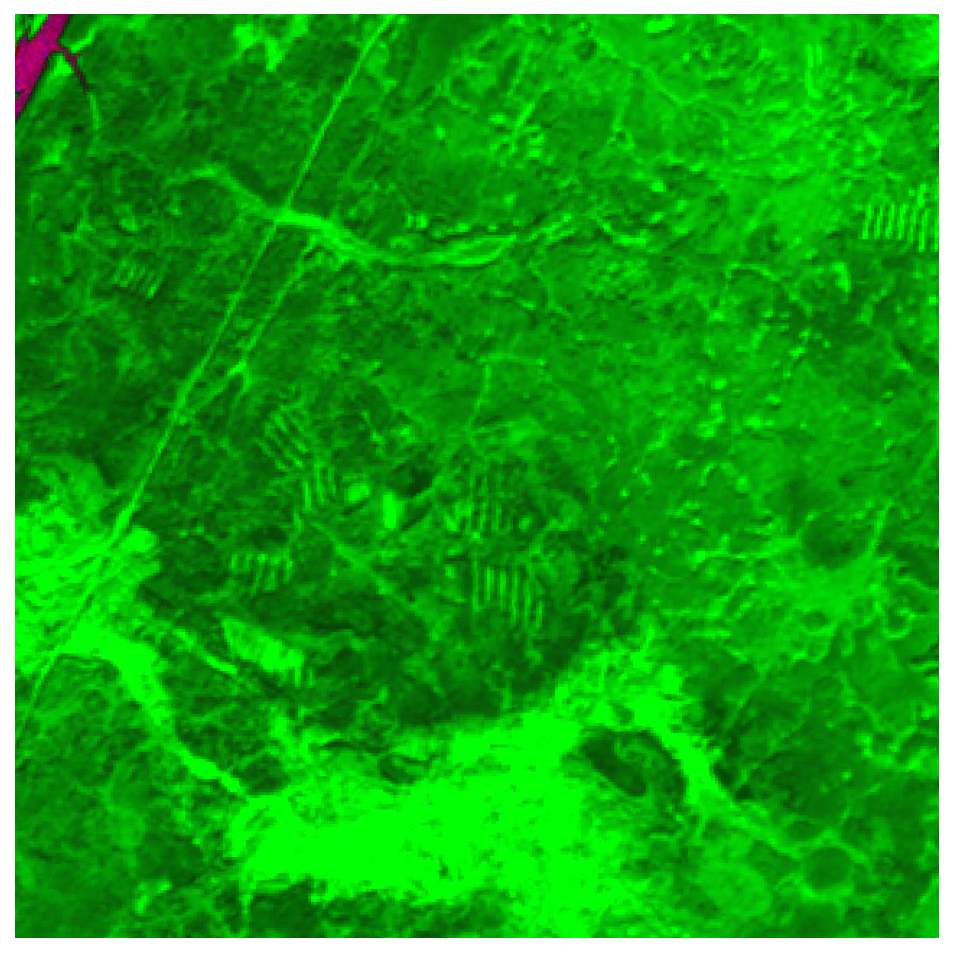

In [69]:
%matplotlib inline
from patched_yolo_infer import visualize_results

#boxes=result.filtered_boxes

# Visualizing the results using the visualize_results function
visualize_results(
    img=result.image,
    masks = result.filtered_masks,
    confidences=result.filtered_confidences,
    boxes=result.filtered_boxes,
    polygons=result.filtered_polygons,
    classes_ids=result.filtered_classes_id,
    classes_names=result.filtered_classes_names,
    segment=True,
)

In [174]:
result

In [92]:
image_path = 'D:/hack2024/pfo/dataset_off/data_yolo/val/images/tile_1_5.png'

In [95]:
from ultralytics import YOLO
from ultralytics.utils.ops import scale_image
import cv2
import numpy as np


def predict_on_image(model, img, conf):
    result = model(img, conf=conf)[0]

    # detection
    # result.boxes.xyxy   # box with xyxy format, (N, 4)
    cls = result.boxes.cls.cpu().numpy()    # cls, (N, 1)
    probs = result.boxes.conf.cpu().numpy()  # confidence score, (N, 1)
    boxes = result.boxes.xyxy.cpu().numpy()   # box with xyxy format, (N, 4)

    # segmentation
    masks = result.masks     # masks, (N, H, W)
    masks = np.moveaxis(masks, 0, -1) # masks, (H, W, N)
    # rescale masks to original image
    masks = scale_image(masks.shape[:2], masks, result.masks.orig_shape)
    masks = np.moveaxis(masks, -1, 0) # masks, (N, H, W)

    return boxes, masks, cls, probs


def overlay(image, mask, color, alpha, resize=None):

    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

In [96]:
img = cv2.imread(image_path)
boxes, masks, cls, probs = predict_on_image(model, img, conf=0.3)


0: 640x640 2 waters, 24.9ms
Speed: 3.0ms preprocess, 24.9ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

In [91]:
img = Image.open(image_path)

# Perform prediction
results = model.predict(image_path)

masks = results.pred[0][:, 6:]  # Assuming masks are stored after the 6th column
class_ids = results.pred[0][:, 5].int().tolist()  # Assuming class IDs are in the 5th column

# Visualize results
plt.imshow(np.array(img))
for mask, class_id in zip(masks, class_ids):
    mask = mask.cpu().numpy()
    plt.contour(mask, levels=[0.5], colors='r')  # Draw contour for mask
    plt.text(mask.shape[1] // 2, mask.shape[0] // 2, str(class_id), color='white')

plt.show()


image 1/1 D:\hack2024\pfo\dataset_off\data_yolo\val\images\tile_1_5.png: 640x640 4 waters, 42.2ms
Speed: 2.5ms preprocess, 42.2ms inference, 17.9ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'list' object has no attribute 'pred'